# GD2 프로젝트: CutMix 또는 Mixup 비교실험하기

## Augmentation을 적용한 데이터셋 만들기

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


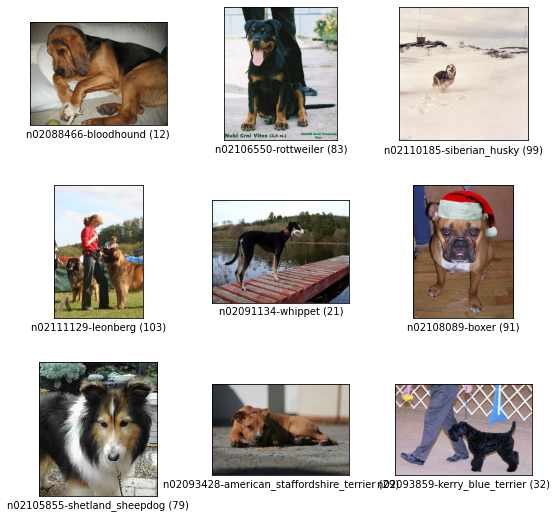

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


fig = tfds.show_examples(ds_info, ds_train)

In [2]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

### cutmix 함수

In [3]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [4]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [5]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [6]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### mixup 함수

In [7]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [8]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 기본 normalize, 기본 aug, onehot

In [9]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [10]:
def onehot(image,label):
    label = tf.one_hot(label, num_classes)    
    return image,label

### normalize 전체 과정 

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
# batch 함수 뒤에 CutMix가 오도록 만든다.
# CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에,
# 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
# 아... 그치 서로 섞일 대상들을 한정시켜놓아야한다!
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2                    
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 데이터 준비하기
- ds_train_no_aug : 기본 데이터
- ds_train_aug : 기본 aug 적용 데이터
- ds_train_cutmix : cutmix 적용 데이터
- ds_train_aug_cutmix : 기본 aug + cutmix 적용 데이터
- ds_train_mixup : mixup 적용 데이터

In [12]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_cutmix=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test,is_test = True)

## 모델 만들기
ResNet-50 사용

In [13]:
## aug 없는 기본 데이터셋, 기본 aug 적용한 데이터셋에 대한 결과는 이미 노드에서 얻음.

# resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224, 224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

# aug_resnet50 = keras.models.Sequential([
#     keras.applications.resnet.ResNet50(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224, 224,3),
#         pooling='avg',
#     ),
#     keras.layers.Dense(num_classes, activation = 'softmax')
# ])

In [14]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [15]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [16]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 모델 훈련하기
sparse_categorical_crossentropy 대신 categorical_crossentropy 사용하자.

https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy


클래스간 상호 exclusive 한 경우 _ 그니까, 경계가 모호하지 않고 각 데이터가 정확히 하나의 클래스에 포함되어있는 경우! 에는 sparse_categorical_crossentropy 를 사용한다.
그게 아니라, 하나의 샘플에 여러 클래스가 있을 수 있거나, 라벨이 'soft probability' 인 경우 (노드 설명 예시에서 나온 \[0.6,0.4\] 이런식으로)에는 categorical_crossentropy 를 사용한다.

In [17]:
tf.random.set_seed(2020)

In [18]:
import os
import pickle

In [19]:
# no_aug 모델 학습 결과 : 노드 진행중 얻음
# 기본 aug 모델 학습 결과 : 노드 진행중 얻음

# cutmix만 적용한 데이터 대상
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # citmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

tf.keras.models.save_model(cutmix_resnet50,'gd2_proj_cutmix_resnet50')
np.save(os.getenv('HOME')+'/aiffel/gd2_train_history/proj_resnet_cutmix.npy',history_resnet50_cutmix.history)

Epoch 1/20
750/750 [==============================] - 129s 172ms/step - loss: 3.8068 - accuracy: 0.2136 - val_loss: 3.4896 - val_accuracy: 0.1965
Epoch 2/20
750/750 [==============================] - 134s 179ms/step - loss: 2.9348 - accuracy: 0.4372 - val_loss: 1.3851 - val_accuracy: 0.6140
Epoch 3/20
750/750 [==============================] - 135s 179ms/step - loss: 2.6656 - accuracy: 0.5158 - val_loss: 1.2790 - val_accuracy: 0.6521
Epoch 4/20
750/750 [==============================] - 135s 179ms/step - loss: 2.4427 - accuracy: 0.5876 - val_loss: 1.2161 - val_accuracy: 0.6781
Epoch 5/20
750/750 [==============================] - 134s 179ms/step - loss: 2.2904 - accuracy: 0.6367 - val_loss: 1.2518 - val_accuracy: 0.6603
Epoch 6/20
750/750 [==============================] - 135s 179ms/step - loss: 2.1632 - accuracy: 0.6786 - val_loss: 1.1438 - val_accuracy: 0.6906
Epoch 7/20
750/750 [==============================] - 135s 179ms/step - loss: 2.0731 - accuracy: 0.7034 - val_loss: 1.2341 -

In [20]:
# no_aug 모델 학습 결과 : 노드 진행중 얻음
# 기본 aug 모델 학습 결과 : 노드 진행중 얻음

# aug, cutmix 적용 데이터 대상
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # citmix, aug 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

tf.keras.models.save_model(aug_cutmix_resnet50,'gd2_proj_aug_cutmix_resnet50')

np.save(os.getenv('HOME')+'/aiffel/gd2_train_history/proj_resnet_aug_cutmix.npy',history_resnet50_aug_cutmix.history)

Epoch 1/20
750/750 [==============================] - 135s 180ms/step - loss: 3.8542 - accuracy: 0.2072 - val_loss: 3.3390 - val_accuracy: 0.2147
Epoch 2/20
750/750 [==============================] - 135s 180ms/step - loss: 2.9967 - accuracy: 0.4094 - val_loss: 1.5978 - val_accuracy: 0.5549
Epoch 3/20
750/750 [==============================] - 135s 180ms/step - loss: 2.7140 - accuracy: 0.4964 - val_loss: 1.2220 - val_accuracy: 0.6476
Epoch 4/20
750/750 [==============================] - 136s 181ms/step - loss: 2.5541 - accuracy: 0.5493 - val_loss: 1.3795 - val_accuracy: 0.6186
Epoch 5/20
750/750 [==============================] - 142s 190ms/step - loss: 2.4288 - accuracy: 0.5879 - val_loss: 1.3302 - val_accuracy: 0.6365
Epoch 6/20
750/750 [==============================] - 141s 188ms/step - loss: 2.3208 - accuracy: 0.6193 - val_loss: 1.0865 - val_accuracy: 0.7003
Epoch 7/20
750/750 [==============================] - 142s 189ms/step - loss: 2.2367 - accuracy: 0.6398 - val_loss: 1.0666 -

In [21]:
# no_aug 모델 학습 결과 : 노드 진행중 얻음
# 기본 aug 모델 학습 결과 : 노드 진행중 얻음

# mixup 적용 데이터 대상
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

tf.keras.models.save_model(mixup_resnet50,'gd2_proj_mixup_resnet50')

np.save(os.getenv('HOME')+'/aiffel/gd2_train_history/proj_resnet_mixup.npy',history_resnet50_mixup.history)

Epoch 1/20
750/750 [==============================] - 144s 192ms/step - loss: 3.7408 - accuracy: 0.2323 - val_loss: 4.1095 - val_accuracy: 0.0995
Epoch 2/20
750/750 [==============================] - 144s 191ms/step - loss: 2.8734 - accuracy: 0.4739 - val_loss: 1.3664 - val_accuracy: 0.6125
Epoch 3/20
750/750 [==============================] - 144s 192ms/step - loss: 2.5895 - accuracy: 0.5817 - val_loss: 1.3936 - val_accuracy: 0.6259
Epoch 4/20
750/750 [==============================] - 144s 192ms/step - loss: 2.4209 - accuracy: 0.6367 - val_loss: 1.2531 - val_accuracy: 0.6537
Epoch 5/20
750/750 [==============================] - 144s 192ms/step - loss: 2.2879 - accuracy: 0.6927 - val_loss: 1.3186 - val_accuracy: 0.6398
Epoch 6/20
750/750 [==============================] - 144s 192ms/step - loss: 2.1717 - accuracy: 0.7404 - val_loss: 1.2743 - val_accuracy: 0.6498
Epoch 7/20
750/750 [==============================] - 144s 192ms/step - loss: 2.1176 - accuracy: 0.7592 - val_loss: 1.2601 -

In [22]:
# import os
# import pickle

# histories = [history_resnet50_cutmix,history_resnet50_aug_cutmix,history_resnet50_mixup]

# np.save(os.getenv('HOME')+'/aiffel/gd2_train_history/proj_resnet_cutmix.npy',history_resnet50_cutmix.history)

# np.save(os.getenv('HOME')+'/aiffel/gd2_train_history/proj_resnet_aug_cutmix.npy',history_resnet50_aug_cutmix.history)

# np.save(os.getenv('HOME')+'/aiffel/gd2_train_history/proj_resnet_mixup.npy',history_resnet50_mixup.history)

## 훈련과정 시각화하기

In [26]:
history_resnet50_no_aug = np.load(os.getenv('HOME')+'/aiffel/gd2_train_history/resnet_no_aug.npy', allow_pickle=True)
history_resnet50_aug = np.load(os.getenv('HOME')+'/aiffel/gd2_train_history/resnet_aug.npy',  allow_pickle=True)

In [36]:
history_resnet50_no_aug[()]['val_accuracy']

[0.17094215750694275,
 0.6795709133148193,
 0.714668869972229,
 0.7341417670249939,
 0.7461520433425903,
 0.7437033653259277,
 0.7446361780166626,
 0.7458022236824036,
 0.738456130027771,
 0.7434701323509216,
 0.7473180890083313,
 0.7438199520111084,
 0.7475513219833374,
 0.7435867786407471,
 0.7486007213592529,
 0.7416045069694519,
 0.748833954334259,
 0.7403218150138855,
 0.7466184496879578,
 0.7486007213592529]

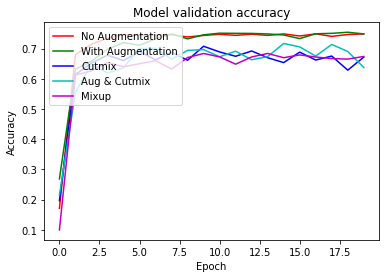

In [38]:
plt.plot(history_resnet50_no_aug[()]['val_accuracy'], 'r')
plt.plot(history_resnet50_aug[()]['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Cutmix','Aug & Cutmix', 'Mixup'], loc='upper left')
plt.show()


조금 더 자세히보기

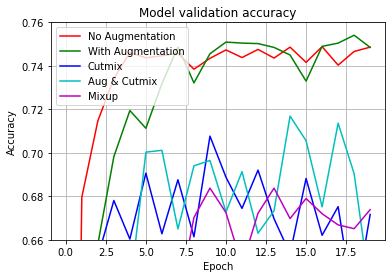

In [43]:
plt.plot(history_resnet50_no_aug[()]['val_accuracy'], 'r')
plt.plot(history_resnet50_aug[()]['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Cutmix','Aug & Cutmix', 'Mixup'], loc='upper left')

plt.grid(True)
plt.ylim(0.66, 0.76)
plt.show()

## Augmentation에 의한 모델 성능 비교

validation accuracy를 비교한 결과, cutmix나 mixup 방법보다 기본 augmentation 을 적용한 결과가 더 좋았고, 그마저도 augmentation을 적용하지 않은 결과와 크게 다르지 않았다.

# 결과보고서

Cutmix, Mixup 같은 비교적 최신의 Augmentation 방ㅇ법들을 알아보고 간단하게 구현해볼 수 있는 점이 흥미로웠다.   
하지만, 결과가 오히려 기본 augmentation을 적용한 것, 심지어 augmentation을 적용하지 않을 것보다 좋지 않은 결과를 내는 것을 관찰할 수 있었다. 역시 좋아보이는 새로운 방법이 나왔다고 해서 무비판적으로 대충 사용하면 더 좋은 결과를 도출할 수 있겠다는 생각으로 접근해서는 안되고, 그 방법을 최대한 잘 활용할 수 있는 다른 요소들에 대해서도 함께 고민해야한다는 생각이 들었다.